In [2]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

### Load data

In [6]:
direc = Path('data/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,data/Fish_Dataset/Fish_Dataset/Red Mullet/Red ...,Red Mullet
1,data/Fish_Dataset/Fish_Dataset/Striped Red Mul...,Striped Red Mullet
2,data/Fish_Dataset/Fish_Dataset/Hourse Mackerel...,Hourse Mackerel
3,data/Fish_Dataset/Fish_Dataset/Striped Red Mul...,Striped Red Mullet
4,data/Fish_Dataset/Fish_Dataset/Striped Red Mul...,Striped Red Mullet


### Display first 9 images as a test

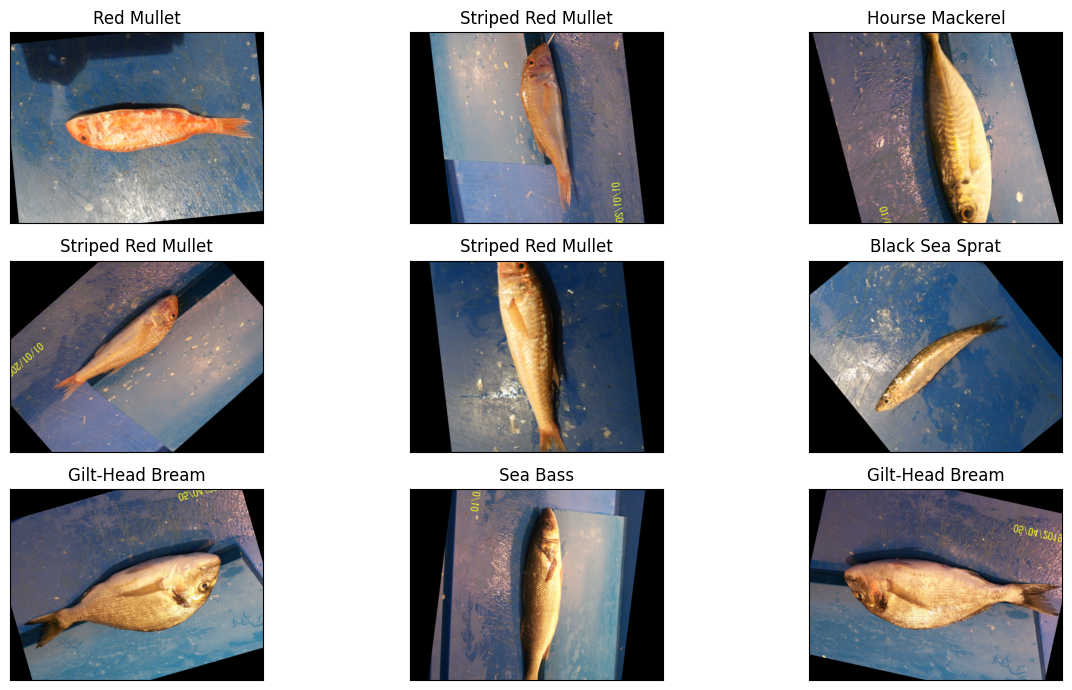

In [11]:
# Showing 9Images 
import matplotlib.pyplot as plt

f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

### Shape of dataframe

In [12]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")


 Count of Rows : 9000 
 Count of Columns : 2 


### Types of fish

In [13]:
img_df['Labels'].value_counts(ascending=True)

Red Mullet            1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Gilt-Head Bream       1000
Sea Bass              1000
Trout                 1000
Red Sea Bream         1000
Shrimp                1000
Name: Labels, dtype: int64

### Splitting the data

In [14]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


### Augmenating The Data

In [15]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


### Creating The Model

In [16]:
### TODO: Find out what this line means
#   tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
### TODO: Find out why we have a softmax layer at the end
#   tf.keras.layers.Dense(9,activation="softmax")

### TODO: Find out why we use categorical_crossentropy loss function

fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="Adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

### Training the model

In [17]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10


2023-04-14 15:07:46.064673: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


211/211 [==============================] - 62s 288ms/step - loss: 1.5225 - accuracy: 0.4508 - val_loss: 1.0592 - val_accuracy: 0.6400
Epoch 2/10
211/211 [==============================] - 60s 286ms/step - loss: 0.9235 - accuracy: 0.6773 - val_loss: 0.7706 - val_accuracy: 0.7444
Epoch 3/10
211/211 [==============================] - 60s 284ms/step - loss: 0.6316 - accuracy: 0.7850 - val_loss: 0.5249 - val_accuracy: 0.8444
Epoch 4/10
211/211 [==============================] - 60s 285ms/step - loss: 0.4641 - accuracy: 0.8437 - val_loss: 0.4578 - val_accuracy: 0.8433
Epoch 5/10
211/211 [==============================] - 60s 284ms/step - loss: 0.3433 - accuracy: 0.8825 - val_loss: 0.4144 - val_accuracy: 0.8600
Epoch 6/10
211/211 [==============================] - 60s 286ms/step - loss: 0.2717 - accuracy: 0.9101 - val_loss: 0.3300 - val_accuracy: 0.8811
Epoch 7/10
211/211 [==============================] - 61s 287ms/step - loss: 0.2242 - accuracy: 0.9244 - val_loss: 0.3191 - val_accuracy: 0.8

### Model summary

In [19]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 9) 

In [20]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 [==============================] - 11s 247ms/step - loss: 0.1940 - accuracy: 0.9311
Test accuracy is :  93.11110973358154 %


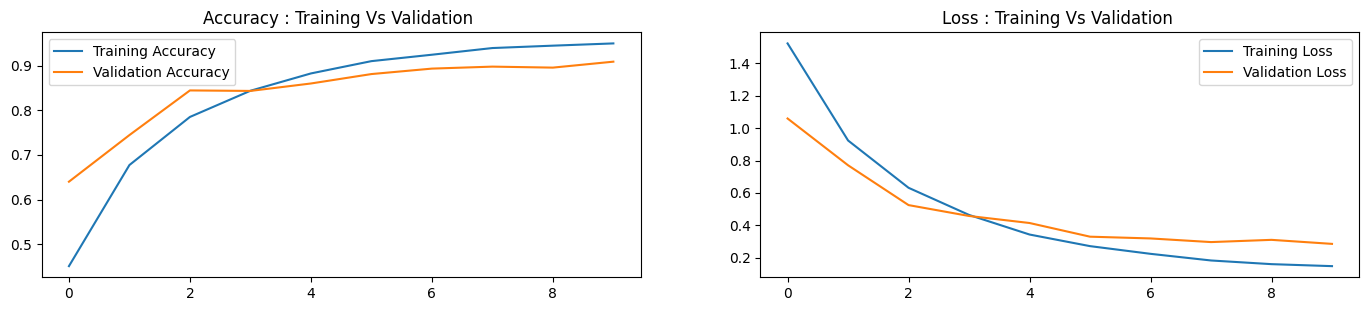

In [21]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()